In [1]:
import datetime
print('Last updated: ', datetime.datetime.now(), '(PT)')

Last updated:  2020-06-29 17:29:44.630622 (PT)


In [2]:
import json
import matplotlib.pyplot as plt
from jax import random
import jax.numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
# from pyro.optim import Adam
# from pyro.infer import SVI, Trace_ELBO
# from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete
# from pyro.contrib.autoguide import AutoDiagonalNormal
from numpyro.infer import MCMC, NUTS, HMC

In [3]:
# Stick break function
def stickbreak(v):
    cumprod_one_minus_v = np.exp(np.log1p(-v).cumsum(-1))
    # cumprod_one_minus_v = np.cumprod(1-v, axis=-1)
    one_v = np.pad(v, (0, 1), constant_values=1)
    c_one = np.pad(cumprod_one_minus_v, (1, 0), constant_values=1)
    return one_v * c_one

# Log sum exp
def logsumexp(x, axis=0, keepdims=False):
    # return np.log(np.sum(np.exp(x), axis=axis))
    mx = np.max(x, axis=axis, keepdims=True)
    out = np.log(np.sum(np.exp(x - mx), axis=axis, keepdims=True)) + mx
    if keepdims:
        return out
    else:
        return out.sum(axis=axis)

In [4]:
# Custom distribution: Mixture of normals.
# This implements the abstract class `dist.Distribution`.
class NormalMixture(dist.Distribution):
    support = constraints.real_vector

    def __init__(self, mu, sigma, w):
        super(NormalMixture, self).__init__(event_shape=(1, ))
        self.mu = mu
        self.sigma = sigma
        self.w = w

    def sample(self, key, sample_shape=()):
        # it is enough to return an arbitrary sample with correct shape
        return np.zeros(sample_shape + self.event_shape)

    def log_prob(self, y, axis=-1):
        lp = dist.Normal(self.mu, self.sigma).log_prob(y) + np.log(self.w)
        return logsumexp(lp, axis=axis)

In [5]:
# Example:
# rng_key = random.PRNGKey(0)
# mu = dist.Normal(0, 1).sample(rng_key, (3, ))
# sig = dist.Uniform(0, 1).sample(rng_key, (3, ))
# w = np.array([.5, .3, .2])
# x = dist.Normal(0, 1).sample(rng_key, (10, 1))
# lp_x = NormalMixture(mu[None, :], sig[None, :], w[None, :]).log_prob(x[:, None])
# print(lp_x.shape)
# print(lp_x)

In [6]:
# DP SB GMM model.
# NOTE: In numpyro, priors are assigned to parameters in the following manner:
#
#   random_variable = numpyro.sample('name_of_random_variable', some_distribution)
#
# Note that random variables appear on the left hand side of the `numpyro.sample` statement.
# Data will appear *inside* the `numpyro.sample` statement, via the obs argument.
# 
# In this example, labels are explicitly mentioned. But they are, in fact, marginalized
# out automatically by numpyro. Hence, they do not appear in the posterior samples.
def dp_sb_gmm(y, num_components):
    # Cosntants
    N = y.shape[0]
    K = num_components
    
    # Priors
    # NOTE: In numpyro, the Gamma distribution is parameterized with shape and rate.
    # Hence, Gamma(shape, rate) => mean = shape/rate
    alpha = numpyro.sample('alpha', dist.Gamma(1, 10))
    
    with numpyro.plate('mixture_weights', K - 1):
        v = numpyro.sample('v', dist.Beta(1, alpha, K - 1))
    
    eta = stickbreak(v)
    
    with numpyro.plate('components', K):
        mu = numpyro.sample('mu', dist.Normal(0., 3.))
        sigma = numpyro.sample('sigma', dist.Gamma(1, 10))

    with numpyro.plate('data', N):
        numpyro.sample('obs', NormalMixture(mu[None, :] , sigma[None, :], eta[None, :]), obs=y[:, None])
    #     Local variables.
    #     label = numpyro.sample('label', dist.Categorical(eta))
    #     numpyro.sample('obs', dist.Normal(mu[label], sigma[label]), obs=y)

In [7]:
# Read simulated data.
path_to_data = '../../data/sim-data/gmm-data-n200.json'
with open(path_to_data) as f:
  simdata = json.load(f)

In [8]:
# Convert data to torch.tensor.
y = np.array(simdata['y'])

In [9]:
# Experimental, syntax not known.

# %%time
# 
# # For ADVI
# from numpyro.infer import SVI, ELBO
# from numpyro.contrib.autoguide import AutoDiagonalNormal
# from numpyro.optim import Adam
# from functools import namedtuple
# from tqdm import trange
# 
# # Set random seed for reproducibility.
# rng_key = random.PRNGKey(0)
# 
# # Automatically define variational distribution.
# guide = AutoDiagonalNormal(dp_sb_gmm)  # a mean field guide
# 
# svi = SVI(dp_sb_gmm, guide, Adam({'lr': 1e-2}), ELBO())
# 
# # do gradient steps
# 
# loss = []
# for step in trange(2000):
#     _loss = svi.update(SVIState, y=y, num_components=10)
#     loss.append(_loss)
#     
# # Plot ELBO    
# plt.plot(loss);

In [15]:
def get_posterior_samples(mcmc):
    # Get posterior samples
    posterior_samples = mcmc.get_samples()

    # `np.apply_along_axis` not implemented in numpyro?
    # TODO: Is there a more efficient way to do this?
    posterior_samples['eta'] = np.vstack([stickbreak(v) for v in posterior_samples['v']]) 
    
    return posterior_samples

In [16]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# NOTE: num_leapfrog = trajectory_length / step_size
kernel = HMC(dp_sb_gmm, step_size=.01, trajectory_length=1) 

hmc = MCMC(kernel, num_samples=500, num_warmup=500)
hmc.run(rng_key, y, 10)

hmc_samples = get_posterior_samples(hmc)

sample: 100%|██████████| 1000/1000 [00:10<00:00, 92.09it/s, 21 steps of size 4.57e-02. acc. prob=0.60] 


CPU times: user 13.7 s, sys: 454 ms, total: 14.1 s
Wall time: 13.2 s


In [24]:
%%time

# Set random seed for reproducibility.
rng_key = random.PRNGKey(0)

# Set up NUTS sampler.
kernel = NUTS(dp_sb_gmm, max_tree_depth=10, target_accept_prob=0.8)

nuts = MCMC(kernel, num_samples=500, num_warmup=500)
nuts.run(rng_key, y, 10)

nuts_samples = get_posterior_samples(nuts)

sample: 100%|██████████| 1000/1000 [00:29<00:00, 33.44it/s, 511 steps of size 7.51e-03. acc. prob=0.83] 


CPU times: user 32.8 s, sys: 406 ms, total: 33.2 s
Wall time: 32.3 s


In [20]:
def plot_param_post(params, param_name, param_full_name, figsize=(12, 4), truth=None):
    plt.figure(figsize=figsize)
    param = params[param_name]

    plt.subplot(1, 2, 1)
    plt.boxplot(param.T, whis=[2.5, 97.5], showmeans=True, showfliers=False)
    plt.xlabel('mixture components')
    plt.ylabel(param_full_name)
    plt.title('95% Credible Intervals for {}'.format(param_full_name))
    if truth is not None:
        for line in truth:
            plt.axhline(line, ls=':')

    plt.subplot(1, 2, 2)
    plt.plot(param);
    plt.xlabel('iterations')
    plt.ylabel(param_full_name)
    plt.title('Trace plot of {}'.format(param_full_name));

In [22]:
def plot_all_params(samples):
    # TODO: How to get log-likelihood?
    plot_param_post(samples, 'eta', 'mixture weights', truth=simdata['w'])
    plot_param_post(samples, 'mu', 'mixture means', truth=simdata['mu'])
    plot_param_post(samples, 'sigma', 'mixture scales', truth=simdata['sig'])
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.hist(samples['alpha'], bins=30, density=True);
    plt.xlabel("alpha")
    plt.ylabel("density")
    plt.title("Posterior distribution of alpha");

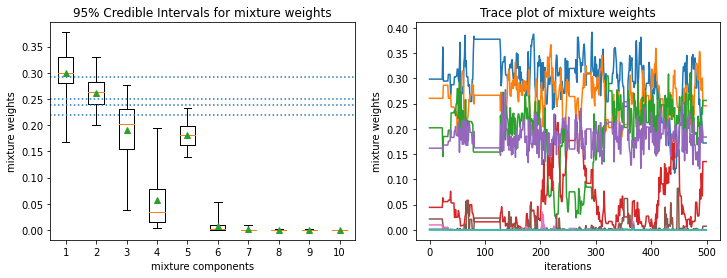

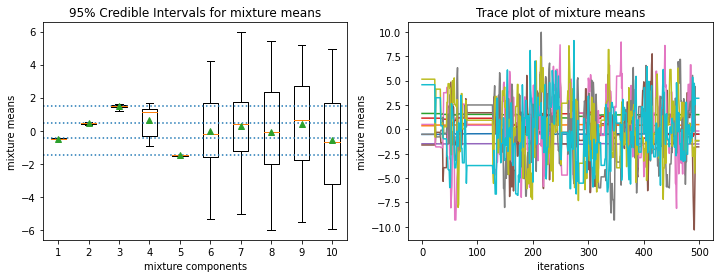

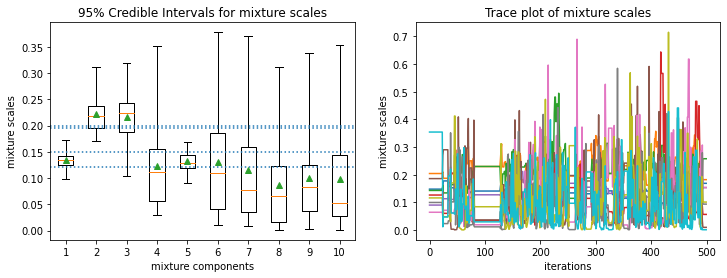

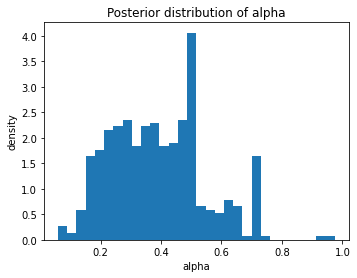

In [23]:
plot_all_params(hmc_samples)

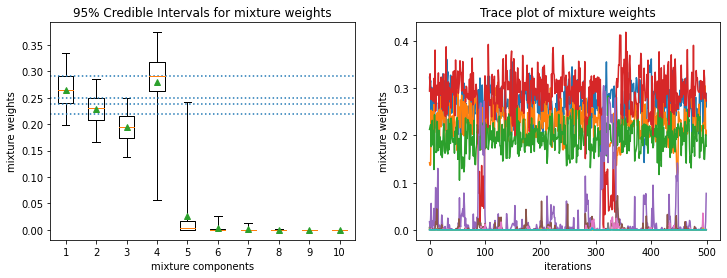

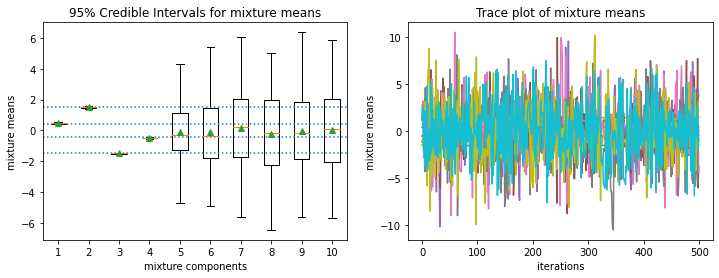

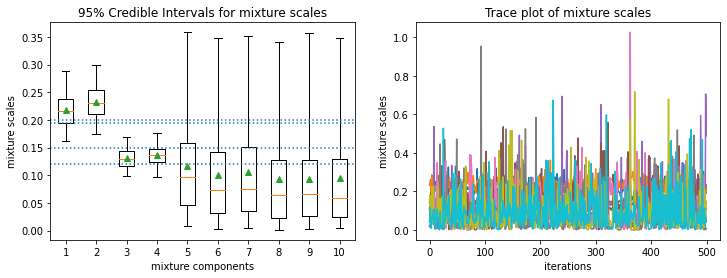

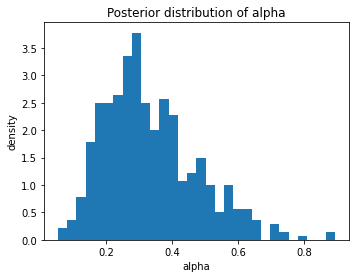

In [25]:
plot_all_params(nuts_samples)